# Описание проекта

Предоставлены данные о качестве нефти и объем ее запасов в трех регионах. Задача построить модель машинного обучения, которая поможет рассчитать прибыль в каждом из трех регионов. Проанализировать возможную прибыль и риски техникой *Bootstrap*. Выбрать регион с вероятностью убытка меньше 2.5% и наибольшей прибылью.

- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода.
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для разработки.

## Описание данных
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# Содержание

1. [Загрузка и подготовка данных](#1.-Загрузка-и-подготовка-данных)
2. [Исследовательский анализ данных](#2.-Исследовательский-анализ-данных)
3. [Обучение и проверка модели](#3.-Обучение-и-проверка-модели)
4. [Подготовка к расчёту прибыли](#4.-Подготовка-к-расчёту-прибыли)
5. [Расчёт прибыли и рисков](#5.-Расчёт-прибыли-и-рисков)  
    5.1 [Применение техники Bootstrap](#5.1-Применение-техники-Bootstrap)  
    5.2 [Анализ рузультата](#5.2-Анализ-результата)
6. [Вывод](#6.-Вывод)

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data_1 = pd.read_csv('./geo_data_0.csv')
data_2 = pd.read_csv('./geo_data_1.csv')
data_3 = pd.read_csv('./geo_data_2.csv')

In [3]:
#выведем три таблицы
display(data_1.head())
display(data_2.head())
display(data_3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
#посмотрим общую информацию о данных
for df in [data_1, data_2, data_3]:
    df.info()
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-N

In [5]:
#посмотрим дубликаты по id
for df in [data_1, data_2, data_3]:
    print('Дубликтов в df:', df['id'].duplicated().sum())

Дубликтов в df: 10
Дубликтов в df: 4
Дубликтов в df: 4


Некоторые скважины повторяются. Повторные наблюдения по скважинам могут быть. Оставим без изменения. Но проверим на полные дубликаты.

In [6]:
#проверим на полные дубликаты строк
count = 0
for df in [data_1, data_2, data_3]:
    count += df.duplicated().sum()
print(count)

0


### Вывод  по результатам предобработки

- Пропусков в данных не обнаруженно.
- Полные дубликаты строк отсутствуют.
- Числовые признаки имеют вещественный тип. Не будем округлять, чтобы не потерять дисперсию признаков, которая будет важна при построении модели. 

# 2. Исследовательский анализ данных

Исследуем данные:
1. Посмотрим распределения признаков. 
2. Поищем выбросы и аномалии. 
3. Посмотрим на взаимосвязи между признаками. 

In [7]:
#посмотрим описательные статистики
for df in [data_1, data_2, data_3]:
    display(df.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Регион 1


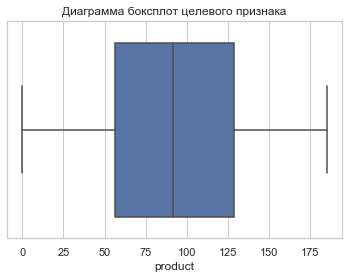

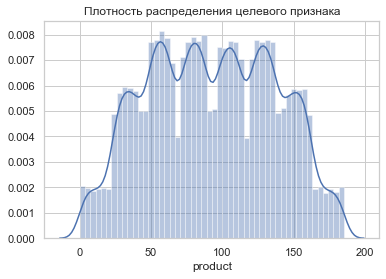

Регион 2


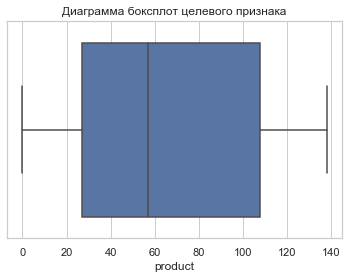

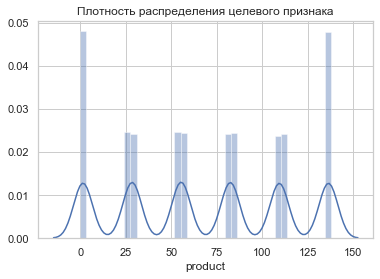

Регион 3


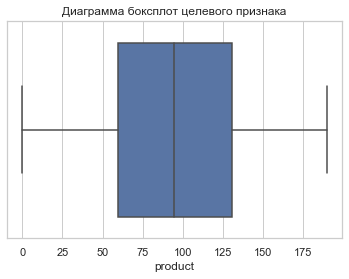

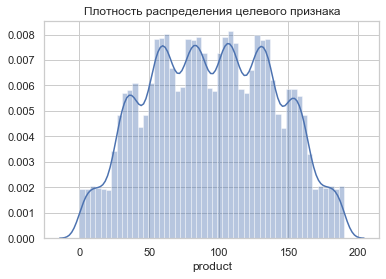

In [8]:
num_reg = 0
#построим диаграммы распределения целевого признака
for df in [data_1, data_2, data_3]:
    num_reg += 1
    print(f'Регион {num_reg}')
    plt.show(sns.boxplot(df['product']).set(title='Диаграмма боксплот целевого признака'))
    plt.show(sns.distplot(df['product']).set(title='Плотность распределения целевого признака'))

- В распределении объема запасов сважин выбросов нет. 
- Распределение ненормальное. 

Регион 1


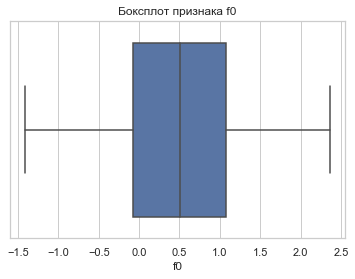

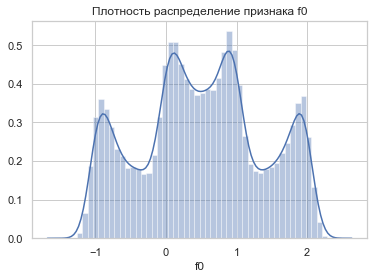

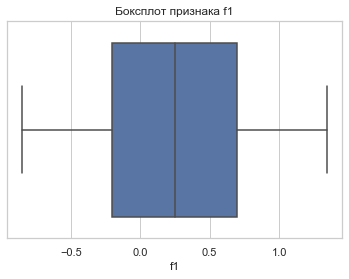

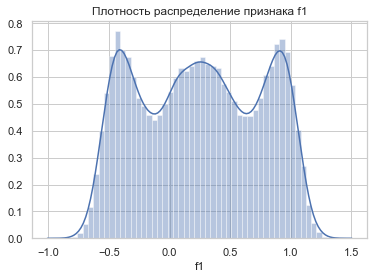

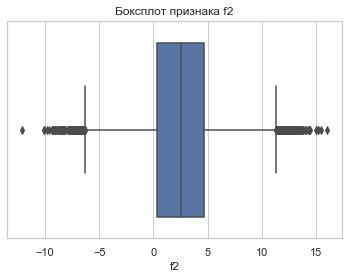

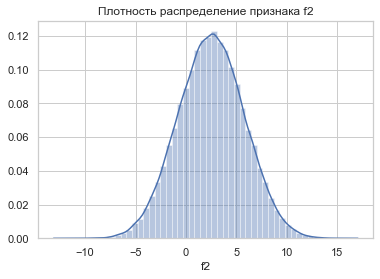

Регион 2


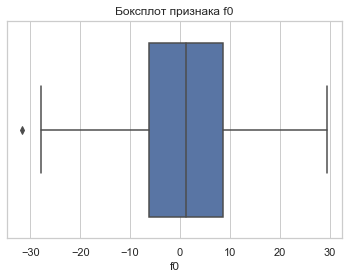

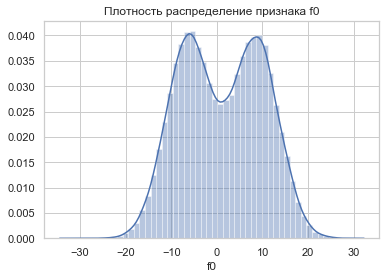

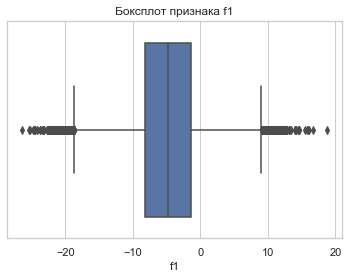

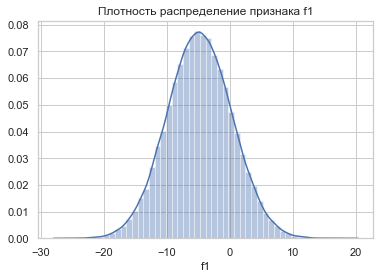

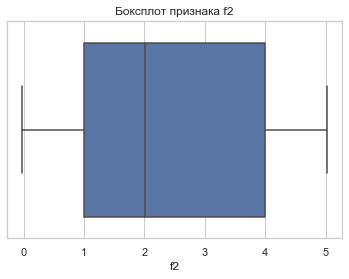

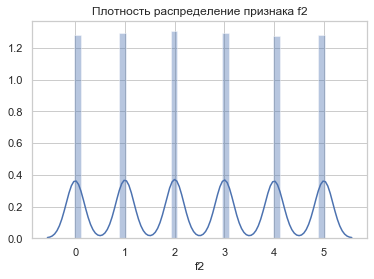

Регион 3


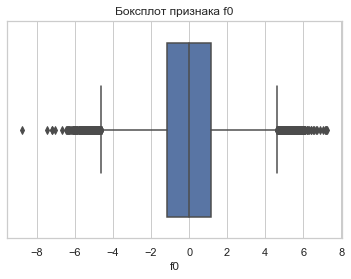

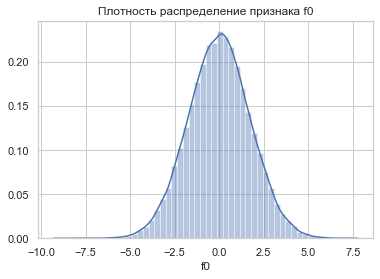

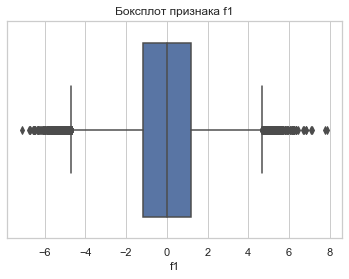

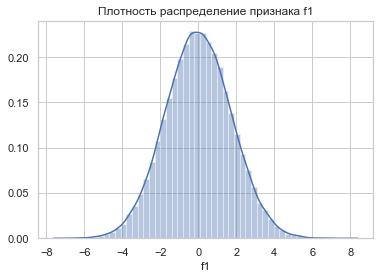

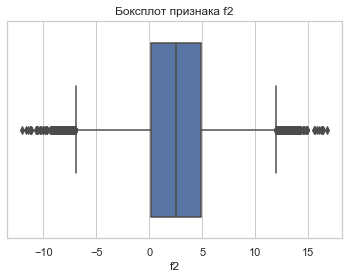

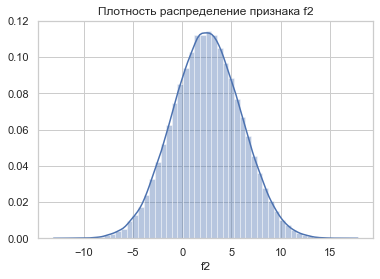

In [9]:
num_reg = 0
for df in [data_1, data_2, data_3]:
    num_reg += 1
    print(f'Регион {num_reg}')
    for i, col in enumerate(df.drop(['product', 'id'], axis=1).columns):
        plt.figure(i)
        plt.show(sns.boxplot(df[col]).set(title=f'Боксплот признака {col}'))
        plt.show(sns.distplot(df[col]).set(title=f'Плотность распределение признака {col}'))

- В признаках наблюдаются выбросы. 
- Исходя из здравого смысло сложно оценить естественную природу аномальных значений данных признаков. 
- Оставим признаки `f0, f1, f2` без измениния, исходя из условий задачи, признаки значимы. 

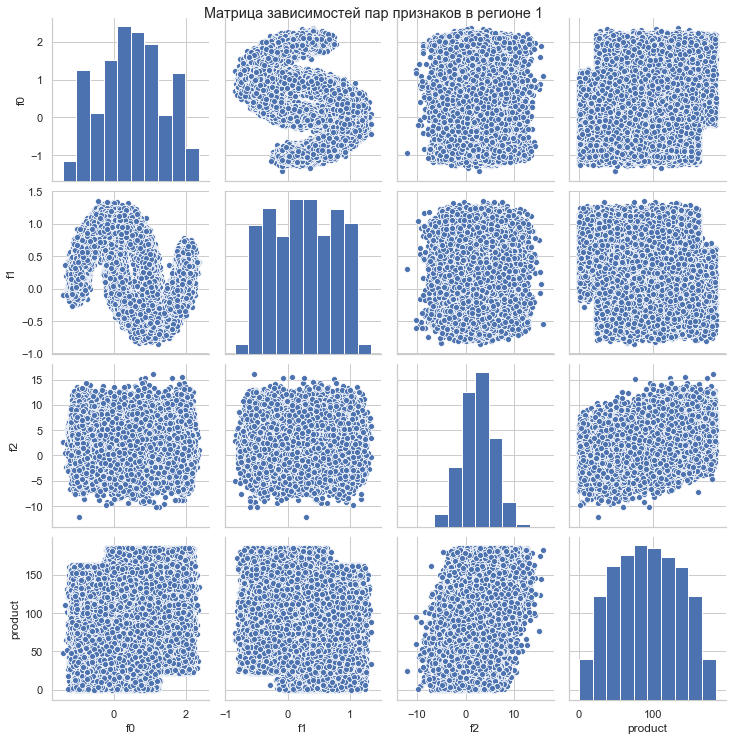

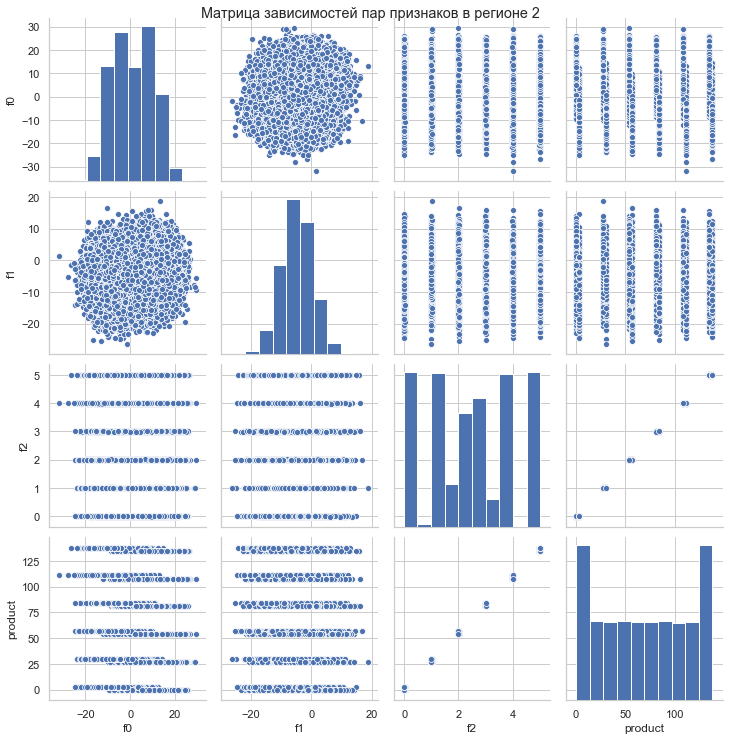

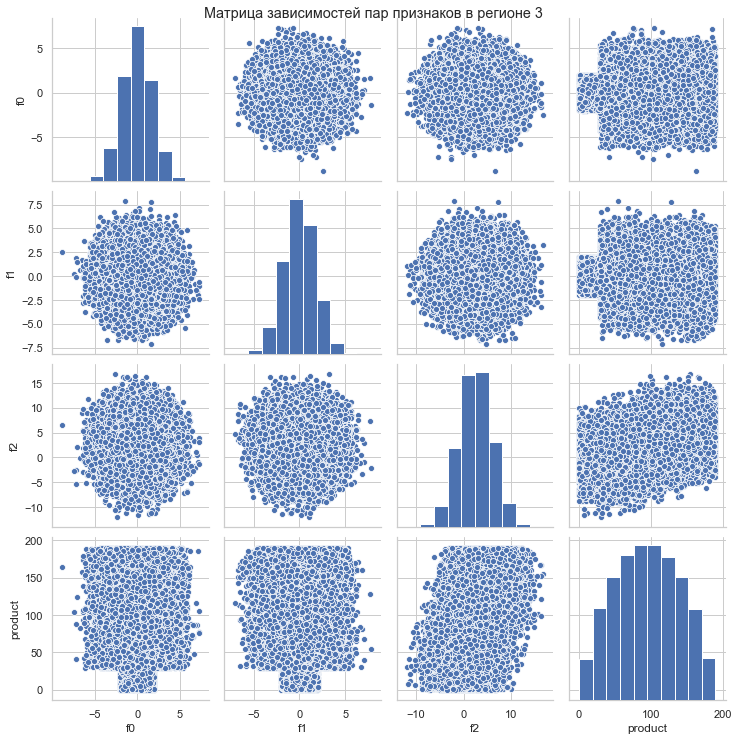

In [10]:
#посмотрим зависимости признаков
num_reg = 0
for df in [data_1, data_2, data_3]:
    num_reg += 1
    sns.pairplot(df).fig.suptitle(f'Матрица зависимостей пар признаков в регионе {num_reg}', y=1.01);

В данном облаке точек не заметно полезной информации. Посмотрим взаимосвязи с помощью коэффициентов корреляции Пирсона. 

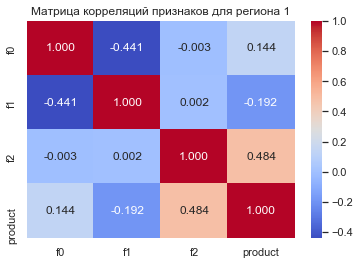

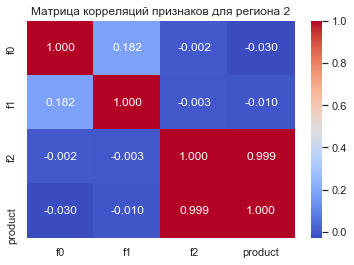

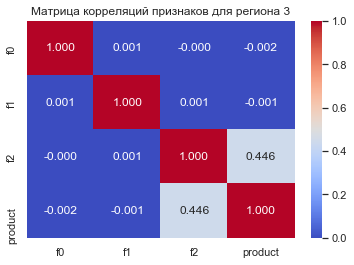

In [11]:
#выведем хитмап со значениями коэфициентов корреляции
num_reg = 0
for df in [data_1, data_2, data_3]:
    num_reg += 1
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.3f').set(
        title=f'Матрица корреляций признаков для региона {num_reg}')
    plt.show()

- у признака `f2` наблюдается средняя корреляция с целевым признаком `product`. Во втором регионе корреляция очень сильная. 
- `f1` - коррелирует слабо, либо не коррелирует. 
- `f0` - не коррелирует с целевым признаком. В первом регионе - слабая.

### Вывод по результатам EDA

- В признаках есть выбросы. Фильтровать выбросы не стали, чтобы не потерять возможные зависимости. 
- В целевом признаке `product` выбросы отсутствуют. 
- Наибольшая корреляция целевого признака наблюнатется с признаком `f2`

# 3. Обучение и проверка модели

Обучим модель для для каждного региона. Посчитаем средний запас предсказанного сырья и RMSE модели.

In [12]:
#определим признаки и целевую переменную
def split_data(data):    
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']

    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=17)
    return features_train, features_valid, target_train, target_valid

features_train_1, features_valid_1, target_train_1, target_valid_1 = split_data(data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_data(data_2)
features_train_3, features_valid_3, target_train_3, target_valid_3 = split_data(data_3)

#созданим списки с выборками трех регионов
features_train = [features_train_1, features_train_2, features_train_3]
features_valid = [features_valid_1, features_valid_2, features_valid_3]
target_train = [target_train_1, target_train_2, target_train_3]
target_valid = [target_valid_1, target_valid_2, target_valid_3]

#проверим полученные размеры выборок
print('Тренировочная выборка для первого региона - фичи и таргет:', features_train_1.shape, target_train_1.shape)
print('Валидационная выборка для первого региона - фичи и таргет:', features_valid_1.shape, target_valid_1.shape)

print('Тренировочная выборка для второго региона - фичи и таргет:', features_train_2.shape, target_train_2.shape)
print('Валидационная выборка для второго региона - фичи и таргет:', features_valid_2.shape, target_valid_2.shape)

print('Тренировочная выборка для третьего региона - фичи и таргет:', features_train_3.shape, target_train_3.shape)
print('Валидационная выборка для третьего региона - фичи и таргет:', features_valid_3.shape, target_valid_3.shape)

Тренировочная выборка для первого региона - фичи и таргет: (75000, 3) (75000,)
Валидационная выборка для первого региона - фичи и таргет: (25000, 3) (25000,)
Тренировочная выборка для второго региона - фичи и таргет: (75000, 3) (75000,)
Валидационная выборка для второго региона - фичи и таргет: (25000, 3) (25000,)
Тренировочная выборка для третьего региона - фичи и таргет: (75000, 3) (75000,)
Валидационная выборка для третьего региона - фичи и таргет: (25000, 3) (25000,)


In [13]:
def learn_model(features_train, target_train, features_valid, target_valid):
    #функция для обучения модели
    #возвращает среднее значение предсказаний и значение ошибки
    model = LinearRegression().fit(features_train, target_train)
    predictions = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predictions)
    rmse = mse ** 0.5
    return predictions, rmse

In [14]:
#создадим словарь, куда будем складывать результаты расчетов
results_dict = { 
    'region': ['первый', 'второй', 'третий'],
    'predictions_mean':[],
                'rmse':[]
}
#словарь для векторов предсказаний
predictions_dict = {}
#выведем ошибку модедели и сохраним результаты в словаре
for i in range(3):
    print(f'Регион {i+1}')
    predictions, rmse = learn_model(features_train[i], target_train[i], features_valid[i], target_valid[i])
    pred_mean = np.mean(predictions)
    predictions_dict['predictions_'+ str(i+1)] = predictions
    results_dict['predictions_mean'].append(pred_mean.round(2))
    results_dict['rmse'].append(rmse.round(2))
    print('Среднее предсказанных значений:', pred_mean.round(2))
    print('RMSE:', rmse.round(2))
    print('\n')

Регион 1
Среднее предсказанных значений: 92.39
RMSE: 37.79


Регион 2
Среднее предсказанных значений: 68.82
RMSE: 0.89


Регион 3
Среднее предсказанных значений: 95.09
RMSE: 40.14




- Третий регион по запасам богаче остальных.
- В втором регионе маленькая ошибка. Вероятно это связано с сильной корреляцией признака `f2`.

# 4. Подготовка к расчёту прибыли

- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [15]:
#цена за 1 тыс. баррлей сырья
PRICE_FOR_ONE_THOU = 450_000

#бюджет на разработку 
BUDGET_FOR_DEVELOP = 10_000_000_000

#количество скважин
COUNT_OILWELL = 200

#расчитаем запас сырья
MATERIAL_VOLUME = int(np.ceil(BUDGET_FOR_DEVELOP / PRICE_FOR_ONE_THOU / COUNT_OILWELL))

print('Необходимый запас сырья, тыс баррелей:', MATERIAL_VOLUME)
print('Средний запас сырья в первом регионе, тыс баррелей:', round(data_1['product'].mean(),1))
print('Средний запас сырья во втором регионе, тыс баррелей:', round(data_2['product'].mean(),1))
print('Средний запас сырья в третьем регионе, тыс баррелей:', round(data_3['product'].mean(),1))

Необходимый запас сырья, тыс баррелей: 112
Средний запас сырья в первом регионе, тыс баррелей: 92.5
Средний запас сырья во втором регионе, тыс баррелей: 68.8
Средний запас сырья в третьем регионе, тыс баррелей: 95.0


Необходимый запас выше чем средний запас в любом из регионов. Третий регион богаче по запасам, чем другие. 

# 5. Расчёт прибыли и рисков 

In [16]:
#переводем предказания в пандовскую серию и поставим индексы из соответствующих датафремов
#для первого региона
predictions_1 = pd.Series(predictions_dict['predictions_1'], index=features_valid_1.index)

#для второго региона
predictions_2 = pd.Series(predictions_dict['predictions_2'], index=features_valid_2.index)

#для третьего региона
predictions_3 = pd.Series(predictions_dict['predictions_3'], index=features_valid_3.index)

#сохраним предсказания в списке
predictions = [predictions_1, predictions_2, predictions_3]

In [17]:
def calculate_profit(predictions, target_valid, count):
    #функция для расчета прибыли
    top_count_idx = predictions.sort_values(ascending=False).index
    sum_material = target_valid[top_count_idx][:count].sum()
    revenue = sum_material * PRICE_FOR_ONE_THOU
    profit = revenue - BUDGET_FOR_DEVELOP
    return profit

In [18]:
target_subsample = target_valid_1.sample(n=500, random_state = 12345, replace=True)
predict_subsample = predictions_1[target_subsample.index]

top_count_idx = predict_subsample.sort_values(ascending=False).index[:200]
sum_material = target_subsample[top_count_idx]
sum_material

29499    146.469536
13284    121.603478
53933    136.477275
13625    151.019130
65278    164.297914
            ...    
59850    127.464950
36421     72.919043
32982     72.608978
97335     75.952089
31019    107.051607
Name: product, Length: 208, dtype: float64

In [19]:
#проверка
target_subsample = target_valid_1.sample(n=500, random_state = 12345, replace=True)
predict_subsample = predictions_1[target_subsample.index]

top_count_idx = predict_subsample.sort_values(ascending=False).index
sum_material = target_subsample[top_count_idx][:200]
sum_material 

29499    146.469536
13284    121.603478
53933    136.477275
13625    151.019130
65278    164.297914
            ...    
36821    158.185786
712       72.279722
10575    139.548330
77084    124.393196
79339     79.261622
Name: product, Length: 200, dtype: float64

In [20]:
def convert_to_billion(x):
    #функция для конвертации значений в миллиарды
    return round(x / 1_000_000_000, 3)

Первый регион
Прибыль: 3.3 млрд


Второй регион
Прибыль: 2.4 млрд


Третий регион
Прибыль: 2.3 млрд




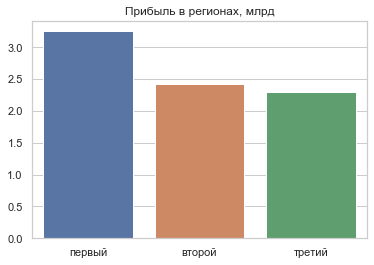

In [21]:
#посчитаем прибыль для трех регионов
#для первого
def print_profit(profit):
    print('Прибыль:', (profit/ 1_000_000_000).round(1),  'млрд')
    print('\n')

    
profit_1 = calculate_profit(predictions_1, target_valid_1, count=COUNT_OILWELL)
results_dict['profit_pred'] = []
results_dict['profit_pred'].append(convert_to_billion(profit_1))
print('Первый регион')
print_profit(profit_1)

#для второго
profit_2 = calculate_profit(predictions_2, target_valid_2, count=COUNT_OILWELL)
results_dict['profit_pred'].append(convert_to_billion(profit_2))
print('Второй регион')
print_profit(profit_2)

#для третьего
profit_3 = calculate_profit(predictions_3, target_valid_3, count=COUNT_OILWELL)
results_dict['profit_pred'].append(convert_to_billion(profit_3))
print('Третий регион')
print_profit(profit_3)

#построим диаграмму для прибыли в трех регионах
sns.barplot(y=results_dict['profit_pred'], x=results_dict['region']).set(title='Прибыль в регионах, млрд');

## 5.1 Применение техники Bootstrap

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [22]:
state = np.random.RandomState(12345)

def bootstrap(predictions, target_valid, boot_it=1000, random_state=state):
    #функция для расчета прибыли через технику бутстрап
    #возвращает вектор значений прибыли, нижнюю и верхнюю границы доверительного интервала
    values = []
    for i in range(boot_it):
        target_subsample = target_valid.sample(n=500, random_state = state, replace=True)
        predict_subsample = predictions[target_subsample.index]
        profit_subsample = calculate_profit(predict_subsample, target_subsample, 200)
    
        values.append(profit_subsample)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    
    return values, lower, upper

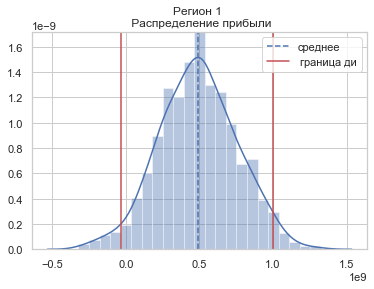

Среднее значение прибыли, млрд.: 0.491
95% доверительный интервал, млрд.: -0.036 - 0.999
Риск убытка: 3.40%




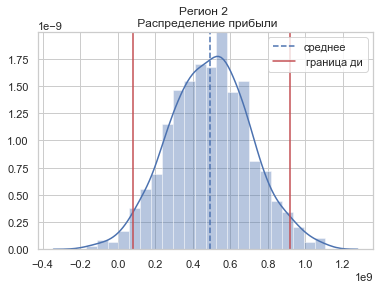

Среднее значение прибыли, млрд.: 0.491
95% доверительный интервал, млрд.: 0.082 - 0.92
Риск убытка: 1.10%




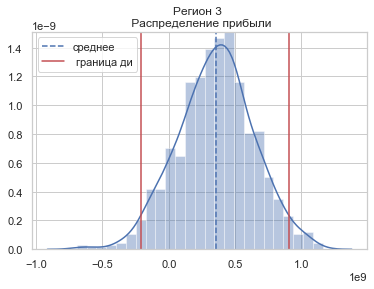

Среднее значение прибыли, млрд.: 0.355
95% доверительный интервал, млрд.: -0.208 - 0.908
Риск убытка: 11.70%




In [23]:
#создадим списки в словаре для результатов расчета среденей прибыли, доверительного интервала, вероятности убытков
results_dict['profit_booted_mean'] = []
results_dict['trust_interval'] = []
results_dict['risk_prob'] = []

#построим диаграммы распределение прибыли для трех регионов
for i in range(3):
    values, lower, upper = bootstrap(predictions[i], target_valid[i], boot_it=1000, random_state=state)
    
    #сохраним результаты в словарь
    results_dict['profit_booted_mean'].append(convert_to_billion(values.mean()))
    results_dict['trust_interval'].append(tuple([convert_to_billion(lower), convert_to_billion(upper)]))
    results_dict['risk_prob'].append((values < 0).mean())
    
    sns.distplot(values).set(title=f'Регион {i+1} \n Распределение прибыли')
    plt.axvline(values.mean(), label='среднее', linestyle='--')
    plt.axvline(lower, color='r', label=' граница ди')
    plt.axvline(upper, color='r')
    plt.legend()
    plt.show()
    
    print('Среднее значение прибыли, млрд.:', convert_to_billion(values.mean()))
    print('95% доверительный интервал, млрд.:', convert_to_billion(lower), '-',  convert_to_billion(upper))
    print('Риск убытка: {:.2%}'.format((values < 0).mean()))
    print('\n')

## 5.2 Анализ результата

Регион 2 стоит рассмотреть для разраоботки скважин. 
- в первом и втором регионе прибыль на одном уровне. 
- во втором регионе риск убытка меньше 2.5%, в остальных - выше.
- в третьем регионе наименьшая прибыль.  

In [24]:
#преобразуем результаты в датафрейм
results = pd.DataFrame(results_dict)
results.columns = ['Регион', 
                   'Среднее предсказаных запасов, тыс.баррелей',
                    'RMSE', 
                    'Прибыль от выбранных скважин, млрд',
                    'Средняя прибыль по бутстрапу, млрд', 
                    '95 % доверительный интервал, млрд',
                    'Вероятность убытка']

In [25]:
#выведем результаты по трем регионам
results.style.set_caption('Результаты расчетов в трех регионах')

,Регион,"Среднее предсказаных запасов, тыс.баррелей",RMSE,"Прибыль от выбранных скважин, млрд","Средняя прибыль по бутстрапу, млрд","95 % доверительный интервал, млрд",Вероятность убытка
0,первый,92.390000,37.790000,3.251000,0.491000,"(-0.036, 0.999)",0.034000
1,второй,68.820000,0.890000,2.415000,0.491000,"(0.082, 0.92)",0.011000
2,третий,95.090000,40.140000,2.301000,0.355000,"(-0.208, 0.908)",0.117000


# 6. Вывод

В ходе работы мы выполнили:
   1. Провели предобработку и первичный анализ данных.
   2. Разбили выборки на обучающую и валидационную в соотношении 75:25.
   3. Построили модель линейной регрессии для каждого региона. Предсказали запасы сырья в каждом регионе. Во втором регионе получилась наименьшая ошибка модели, но при этом наименьший запас сырья. 
   4. На валидацииной выборке посчитали прибыль по отобранным моделью скважинам. Наибольшая прибыль в первом регионе. 
   5. Техникой бутстрап с 1000 выборок расчитали распределение прибыли в регионах. Расчитали доверительных интервал и вероятность убытков. Вероятность убытков меньше 2.5 % получилась только регионе 2. При этом средня прибыль не уступает остальным регионам. Исходя из полученных результатов, для разработки скважин следует выбрать второй регион.